In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt

file_path = r"C:/Users/ZITIAO/Desktop/merged_for_regression_cleaned.csv"
df = pd.read_csv(file_path)

print(df.shape)
df.head()


(2125, 14)


,OPERATOR NAME,Year,SUBSTANCE NAME,Total Emission (kg),Employee,Turnover,Turnover_million,REGULATED INDUSTRY SECTOR,REGULATED INDUSTRY SUB SECTOR,log_emission,log_employee,log_turnover,Sector,SubSector
0,anglian water,2016,Benzo(a)pyrene,1.15,4432.0,1.185000e+09,1185.0,Water Industry,Water Industry,0.139762,8.396606,7.077498,Water Industry,Water Industry
1,anglian water,2016,Benzo(a)pyrene,1.15,4432.0,1.185000e+09,1185.0,Water Industry,Water Industry,0.139762,8.396606,7.077498,Water Industry,Water Industry
2,anglian water,2016,Benzo(a)pyrene,1.15,4432.0,1.185000e+09,1185.0,Water Industry,Water Industry,0.139762,8.396606,7.077498,Water Industry,Water Industry
3,anglian water,2016,Benzo(a)pyrene,1.15,4432.0,1.185000e+09,1185.0,Water Industry,Water Industry,0.139762,8.396606,7.077498,Water Industry,Water Industry
4,anglian water,2016,Benzo(a)pyrene,1.15,4432.0,1.185000e+09,1185.0,Water Industry,Water Industry,0.139762,8.396606,7.077498,Water Industry,Water Industry


In [4]:
df = df.drop_duplicates(subset=["OPERATOR NAME", "Year", "SUBSTANCE NAME"])
print(df.shape)


(276, 14)


In [6]:
# productivity
df["log_prod"] = df["log_turnover"] - df["log_employee"]

# Strength
df["logE_over_Y"] = np.log(df["Total Emission (kg)"] / df["Turnover"])
df["logE_over_L"] = np.log(df["Total Emission (kg)"] / df["Employee"])

# Delete Inf or Missing
df = df.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["log_emission", "log_turnover", "log_employee"]
)

df = df.set_index(["OPERATOR NAME", "Year"]).sort_index()
df.head()


SUBSTANCE NAME  Total Emission (kg)  Employee  \
OPERATOR NAME Year                                                          
anglian water 2016          Benzo(a)pyrene                 1.15    4432.0   
              2016                  Copper              1672.40    4432.0   
              2016            Fluoranthene                 1.59    4432.0   
              2016  Indeno(1,2,3-cd)pyrene                 6.08    4432.0   
              2017                  Copper              1295.60    4462.0   

                        Turnover  Turnover_million REGULATED INDUSTRY SECTOR  \
OPERATOR NAME Year                                                             
anglian water 2016  1.185000e+09            1185.0            Water Industry   
              2016  1.185000e+09            1185.0            Water Industry   
              2016  1.185000e+09            1185.0            Water Industry   
              2016  1.185000e+09            1185.0            Water Industry   
              2017  1.227000e+09            1227.0            Water Industry   

                   REGULATED INDUSTRY SUB SECTOR  log_emission  log_employee  \
OPERATOR NAME Year                                                             
anglian water 2016                Water Industry      0.139762      8.396606   
              2016                Water Industry      7.422015      8.396606   
              2016                Water Industry      0.463734      8.396606   
              2016                Water Industry      1.805005      8.396606   
              2017                Water Industry      7.166729      8.403352   

                    log_turnover          Sector       SubSector  log_prod  \
OPERATOR NAME Year                                                           
anglian water 2016      7.077498  Water Industry  Water Industry -1.319108   
              2016      7.077498  Water Industry  Water Industry -1.319108   
              2016      7.077498  Water Industry  Water Industry -1.319108   
              2016      7.077498  Water Industry  Water Industry -1.319108   
              2017      7.112327  Water Industry  Water Industry -1.291025   

                    logE_over_Y  logE_over_L  
OPERATOR NAME Year                            
anglian water 2016   -20.753247    -8.256844  
              2016   -13.470994    -0.974591  
              2016   -20.429275    -7.932872  
              2016   -19.088004    -6.591602  
              2017   -13.761109    -1.236623

In [8]:
from linearmodels.panel import PanelOLS

A_results = {}
for p, sub in df.groupby("SUBSTANCE NAME"):
    try:
        mod = PanelOLS(
            sub["log_emission"],
            sub[["log_turnover", "log_employee"]],
            entity_effects=True,
            time_effects=True
        )
        res = mod.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)
        A_results[p] = res
        print(f"\n==== {p} ====")
        print(res.summary.tables[1])  
    except Exception as e:
        print(f"{p} fail: {e}")



==== Benzo(a)pyrene ====
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
log_turnover     0.7467     0.4374     1.7071     0.1013     -0.1581      1.6516
log_employee    -0.9062     0.5189    -1.7464     0.0941     -1.9796      0.1672

==== Copper ====
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
log_turnover    -0.1419     0.2383    -0.5956     0.5538     -0.6190      0.3352
log_employee    -0.2927     0.1877    -1.5591     0.1245     -0.6687      0.0832

==== Cypermethrin ====
                              Parameter Estimates                               
              Parameter  Std. Err.     T-

C:\Users\ZITIAO\anaconda3\Lib\site-packages\linearmodels\panel\results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


In [10]:
import pandas as pd

diag_rows = []
for p, sub in df.groupby("SUBSTANCE NAME"):
    s = sub.dropna(subset=["log_emission","log_turnover","log_employee"]).copy()
    diag_rows.append({
        "pollutant": p,
        "N": len(s),
        "n_firms": s.index.get_level_values(0).nunique(),
        "n_years":  s.index.get_level_values(1).nunique()
    })
diag = pd.DataFrame(diag_rows).sort_values(["n_firms","n_years","N"])
diag


,pollutant,N,n_firms,n_years
0,Benzo(a)pyrene,39,7,8
4,"Indeno(1,2,3-cd)pyrene",40,7,8
2,Cypermethrin,43,10,8
3,Fluoranthene,57,11,8
1,Copper,81,15,8


In [12]:
import numpy as np
import pandas as pd
import warnings
from linearmodels.panel import PanelOLS

def _has_bad_cov(res):
    try:
        cov = np.asarray(res.cov)
        d = np.diag(cov)
        if np.any(~np.isfinite(d)): 
            return True
        if np.any(d < 0):
            return True
        return False
    except Exception:
        return True

def fit_twfe_adaptive(sub_df, y, X):
    mod = PanelOLS(sub_df[y], sub_df[X], entity_effects=True, time_effects=True)

    tries = [
        (dict(cov_type="clustered", cluster_entity=True,  cluster_time=True),   "2-way cluster (firm & year)"),
        (dict(cov_type="clustered", cluster_entity=True,  cluster_time=False),  "1-way cluster (firm)"),
        (dict(cov_type="clustered", cluster_entity=False, cluster_time=True),   "1-way cluster (year)"),
        (dict(cov_type="kernel", kernel="bartlett", bandwidth=3),               "Driscoll–Kraay (kernel)"),
        (dict(cov_type="robust"),                                               "HC-robust"),
    ]

    last = (None, "")
    for kw, label in tries:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)
                res = mod.fit(**kw)
            if _has_bad_cov(res):
                print(f" {label} unstable covariance, backtrack.")
                last = (res, label + " [bad cov]")
                continue
            return res, label
        except Exception as e:
            print(f" {label} fail：{e}")
            last = (None, label + " [fail]")
    return last 

# Estimate
A_results = {}
rows = []
for p, sub in df.groupby("SUBSTANCE NAME"):
    sub = sub.dropna(subset=["log_emission","log_turnover","log_employee"]).copy()
    sub = sub.reset_index().set_index(["OPERATOR NAME","Year"]).sort_index()

    n_firms = sub.index.get_level_values(0).nunique()
    n_years = sub.index.get_level_values(1).nunique()
    if n_firms < 10 or n_years < 3:
        print(f"{p}: Small panel clusters (firms={n_firms}, years={n_years}), fallback.")

    res, cov_used = fit_twfe_adaptive(sub, y="log_emission", X=["log_turnover","log_employee"])
    if res is None:
        print(f"{p}:No usable results")
        continue

    A_results[p] = (res, cov_used)
    coef = res.params
    se   = res.std_errors
    tval = res.tstats
    pval = res.pvalues

    print(f"\n==== {p} ====")
    print(f"Covariance used: {cov_used}")
    out = pd.DataFrame({
        "coef": coef, "std_err": se, "t": tval, "p": pval
    })
    print(out)

    for term in ["log_turnover","log_employee"]:
        rows.append({
            "pollutant": p,
            "term": term,
            "coef": float(coef.get(term, np.nan)),
            "se":   float(se.get(term, np.nan)),
            "t":    float(tval.get(term, np.nan)),
            "p":    float(pval.get(term, np.nan)),
            "cov_used": cov_used,
            "firms": n_firms, "years": n_years, "nobs": int(res.nobs)
        })

A_tidy = pd.DataFrame(rows).sort_values(["pollutant","term"])
A_tidy


Benzo(a)pyrene: Small panel clusters (firms=7, years=8), fallback.

==== Benzo(a)pyrene ====
Covariance used: 2-way cluster (firm & year)
                  coef   std_err         t         p
log_turnover  0.746741  0.437421  1.707145  0.101262
log_employee -0.906175  0.518887 -1.746381  0.094089

==== Copper ====
Covariance used: 2-way cluster (firm & year)
                  coef   std_err         t         p
log_turnover -0.141920  0.238265 -0.595641  0.553773
log_employee -0.292721  0.187746 -1.559133  0.124500

==== Cypermethrin ====
Covariance used: 2-way cluster (firm & year)
                  coef   std_err         t         p
log_turnover  0.166611  0.850813  0.195826  0.846395
log_employee  1.309555  0.971403  1.348106  0.190211

==== Fluoranthene ====
Covariance used: 2-way cluster (firm & year)
                  coef   std_err         t         p
log_turnover -0.047844  0.540660 -0.088491  0.929964
log_employee -0.231171  1.602893 -0.144221  0.886108
Indeno(1,2,3-cd)pyrene: S

,pollutant,term,coef,se,t,p,cov_used,firms,years,nobs
1,Benzo(a)pyrene,log_employee,-0.906175,0.518887,-1.746381,0.094089,2-way cluster (firm & year),7,8,39
0,Benzo(a)pyrene,log_turnover,0.746741,0.437421,1.707145,0.101262,2-way cluster (firm & year),7,8,39
3,Copper,log_employee,-0.292721,0.187746,-1.559133,0.124500,2-way cluster (firm & year),15,8,81
2,Copper,log_turnover,-0.141920,0.238265,-0.595641,0.553773,2-way cluster (firm & year),15,8,81
5,Cypermethrin,log_employee,1.309555,0.971403,1.348106,0.190211,2-way cluster (firm & year),10,8,43
4,Cypermethrin,log_turnover,0.166611,0.850813,0.195826,0.846395,2-way cluster (firm & year),10,8,43
7,Fluoranthene,log_employee,-0.231171,1.602893,-0.144221,0.886108,2-way cluster (firm & year),11,8,57
6,Fluoranthene,log_turnover,-0.047844,0.540660,-0.088491,0.929964,2-way cluster (firm & year),11,8,57
9,"Indeno(1,2,3-cd)pyrene",log_employee,-0.231591,0.375665,-0.616483,0.543380,1-way cluster (firm),7,8,40
8,"Indeno(1,2,3-cd)pyrene",log_turnover,0.670111,0.239700,2.795618,0.010031,1-way cluster (firm),7,8,40


In [14]:
import numpy as np
import pandas as pd

df = df.copy()
df["log_prod"]    = df["log_turnover"] - df["log_employee"]
df["logE_over_Y"] = np.log(df["Total Emission (kg)"] / df["Turnover"])
df["logE_over_L"] = np.log(df["Total Emission (kg)"] / df["Employee"])
df.replace([np.inf, -np.inf], np.nan, inplace=True)

B_rows = []
B_results = {}

for p, sub in df.groupby("SUBSTANCE NAME"):
    sub = sub.reset_index().set_index(["OPERATOR NAME","Year"]).sort_index()

    # B1: log_prod + log_employee）
    sub1 = sub.dropna(subset=["log_emission","log_prod","log_employee"])
    if len(sub1) >= 10:
        res1, cov1 = fit_twfe_adaptive(sub1, y="log_emission", X=["log_prod","log_employee"])
        if res1 is not None:
            print(f"\n==== {p} | B1: log(E) ~ log(Y/L) + log(L) ====\nCovariance used: {cov1}")
            print(pd.DataFrame({"coef":res1.params, "std_err":res1.std_errors, "t":res1.tstats, "p":res1.pvalues}))
            B_results.setdefault(p, {})["prod"] = (res1, cov1)
            for term in ["log_prod","log_employee"]:
                B_rows.append({"pollutant":p,"model":"B1_prod","term":term,
                               "coef":float(res1.params.get(term, np.nan)),
                               "se":float(res1.std_errors.get(term, np.nan)),
                               "t":float(res1.tstats.get(term, np.nan)),
                               "p":float(res1.pvalues.get(term, np.nan)),
                               "cov_used":cov1, "nobs":int(res1.nobs)})

    # B2a: log(E/Y) ~ log(L)
    sub2a = sub.dropna(subset=["logE_over_Y","log_employee"])
    if len(sub2a) >= 10:
        res2a, cov2a = fit_twfe_adaptive(sub2a, y="logE_over_Y", X=["log_employee"])
        if res2a is not None:
            print(f"\n==== {p} | B2a: log(E/Y) ~ log(L) ====\nCovariance used: {cov2a}")
            print(pd.DataFrame({"coef":res2a.params, "std_err":res2a.std_errors, "t":res2a.tstats, "p":res2a.pvalues}))
            B_results.setdefault(p, {})["E_over_Y"] = (res2a, cov2a)
            for term in ["log_employee"]:
                B_rows.append({"pollutant":p,"model":"B2_EoverY","term":term,
                               "coef":float(res2a.params.get(term, np.nan)),
                               "se":float(res2a.std_errors.get(term, np.nan)),
                               "t":float(res2a.tstats.get(term, np.nan)),
                               "p":float(res2a.pvalues.get(term, np.nan)),
                               "cov_used":cov2a, "nobs":int(res2a.nobs)})

    # B2b: log(E/L) ~ log(Y)
    sub2b = sub.dropna(subset=["logE_over_L","log_turnover"])
    if len(sub2b) >= 10:
        res2b, cov2b = fit_twfe_adaptive(sub2b, y="logE_over_L", X=["log_turnover"])
        if res2b is not None:
            print(f"\n==== {p} | B2b: log(E/L) ~ log(Y) ====\nCovariance used: {cov2b}")
            print(pd.DataFrame({"coef":res2b.params, "std_err":res2b.std_errors, "t":res2b.tstats, "p":res2b.pvalues}))
            B_results.setdefault(p, {})["E_over_L"] = (res2b, cov2b)
            for term in ["log_turnover"]:
                B_rows.append({"pollutant":p,"model":"B2_EoverL","term":term,
                               "coef":float(res2b.params.get(term, np.nan)),
                               "se":float(res2b.std_errors.get(term, np.nan)),
                               "t":float(res2b.tstats.get(term, np.nan)),
                               "p":float(res2b.pvalues.get(term, np.nan)),
                               "cov_used":cov2b, "nobs":int(res2b.nobs)})

B_tidy = pd.DataFrame(B_rows).sort_values(["pollutant","model","term"])
B_tidy.head(10)



==== Benzo(a)pyrene | B1: log(E) ~ log(Y/L) + log(L) ====
Covariance used: 2-way cluster (firm & year)
                  coef   std_err         t         p
log_prod      0.746741  0.437421  1.707145  0.101262
log_employee -0.159434  0.386382 -0.412632  0.683697

==== Benzo(a)pyrene | B2a: log(E/Y) ~ log(L) ====
Covariance used: 2-way cluster (firm & year)
                  coef   std_err         t         p
log_employee -1.098697  0.423919 -2.591765  0.015999

==== Benzo(a)pyrene | B2b: log(E/L) ~ log(Y) ====
Covariance used: 2-way cluster (firm & year)
                  coef  std_err         t         p
log_turnover  0.266902  0.48849  0.546383  0.589847

==== Copper | B1: log(E) ~ log(Y/L) + log(L) ====
Covariance used: 2-way cluster (firm & year)
                  coef   std_err         t         p
log_prod     -0.141920  0.238265 -0.595641  0.553773
log_employee -0.434642  0.338453 -1.284200  0.204267

==== Copper | B2a: log(E/Y) ~ log(L) ====
Covariance used: 2-way cluster (firm 

,pollutant,model,term,coef,se,t,p,cov_used,nobs
1,Benzo(a)pyrene,B1_prod,log_employee,-0.159434,0.386382,-0.412632,0.683697,2-way cluster (firm & year),39
0,Benzo(a)pyrene,B1_prod,log_prod,0.746741,0.437421,1.707145,0.101262,2-way cluster (firm & year),39
3,Benzo(a)pyrene,B2_EoverL,log_turnover,0.266902,0.488490,0.546383,0.589847,2-way cluster (firm & year),39
2,Benzo(a)pyrene,B2_EoverY,log_employee,-1.098697,0.423919,-2.591765,0.015999,2-way cluster (firm & year),39
5,Copper,B1_prod,log_employee,-0.434642,0.338453,-1.284200,0.204267,2-way cluster (firm & year),81
4,Copper,B1_prod,log_prod,-0.141920,0.238265,-0.595641,0.553773,2-way cluster (firm & year),81
7,Copper,B2_EoverL,log_turnover,0.104647,0.257426,0.406515,0.685860,2-way cluster (firm & year),81
6,Copper,B2_EoverY,log_employee,0.785142,0.559082,1.404342,0.165550,2-way cluster (firm & year),81
9,Cypermethrin,B1_prod,log_employee,1.476166,1.150882,1.282639,0.211869,2-way cluster (firm & year),43
8,Cypermethrin,B1_prod,log_prod,0.166611,0.850813,0.195826,0.846395,2-way cluster (firm & year),43


In [16]:
work = df.copy().reset_index().set_index(["OPERATOR NAME","Year"]).sort_index()

dummies = pd.get_dummies(work["SUBSTANCE NAME"], prefix="Poll")
for col in dummies.columns:
    work[f"logY_x_{col}"] = work["log_turnover"] * dummies[col]
    work[f"logL_x_{col}"] = work["log_employee"] * dummies[col]

Xcols = [c for c in work.columns if c.startswith("logY_x_") or c.startswith("logL_x_")]
work_C = work.dropna(subset=["log_emission"] + Xcols)

resC, covC = fit_twfe_adaptive(work_C, y="log_emission", X=Xcols)
print(f"Covariance used: {covC}")
C_out = pd.DataFrame({"coef":resC.params, "std_err":resC.std_errors, "t":resC.tstats, "p":resC.pvalues})
C_out


Covariance used: 2-way cluster (firm & year)


,coef,std_err,t,p
logY_x_Poll_Benzo(a)pyrene,0.637536,0.231181,2.757731,0.006317
logL_x_Poll_Benzo(a)pyrene,-0.073574,0.417264,-0.176325,0.860203
logY_x_Poll_Copper,0.023587,0.295474,0.079828,0.936448
logL_x_Poll_Copper,1.142065,0.434053,2.631167,0.009120
logY_x_Poll_Cypermethrin,0.111279,0.305187,0.364624,0.715747
logL_x_Poll_Cypermethrin,0.386211,0.390424,0.989207,0.323663
logY_x_Poll_Fluoranthene,0.737755,0.356188,2.071252,0.039518
logL_x_Poll_Fluoranthene,-0.294804,0.510864,-0.577069,0.564491
"logY_x_Poll_Indeno(1,2,3-cd)pyrene",0.804291,0.321174,2.504220,0.013008
"logL_x_Poll_Indeno(1,2,3-cd)pyrene",-0.163663,0.521848,-0.313622,0.754110


In [18]:
import statsmodels.formula.api as smf

D_rows = []
D_results = {}

for p, sub in df.groupby("SUBSTANCE NAME"):
    sub = sub.reset_index().copy()
    sub["Year_cat"] = sub["Year"].astype(str) 
    sub = sub.dropna(subset=["log_emission","log_turnover","log_employee","Year_cat"])
    if len(sub) < 10:
        print(f"{p}: cross-sectional sample is too small (N={len(sub)}), and the results may be unstable.")

    rhs = "log_turnover + log_employee + C(Year_cat)"
    if "Sector" in sub.columns:    rhs += " + C(Sector)"
    if "SubSector" in sub.columns: rhs += " + C(SubSector)"
    fml = "log_emission ~ log_turnover + log_employee + C(Year_cat) + C(SubSector)" 

    try:
        m = smf.ols(fml, data=sub).fit(cov_type="HC3")
        D_results[p] = m
        print(f"\n==== {p} | OLS + Subsector/year dummies ====")
        print(m.summary().tables[1])

        for term in ["log_turnover","log_employee"]:
            D_rows.append({
                "pollutant": p, "term": term, "coef": float(m.params.get(term, np.nan)),
                "se": float(m.bse.get(term, np.nan)), "t": float(m.tvalues.get(term, np.nan)),
                "p": float(m.pvalues.get(term, np.nan)), "cov_used": "HC3", "nobs": int(m.nobs)
            })
    except Exception as e:
        print(f"{p} OLS fail：{e}")

D_tidy = pd.DataFrame(D_rows).sort_values(["pollutant","term"])
D_tidy.head(10)



==== Benzo(a)pyrene | OLS + Subsector/year dummies ====
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -8.9028      4.191     -2.124      0.034     -17.117      -0.689
C(Year_cat)[T.2017]                        0.2707      0.479      0.565      0.572      -0.668       1.209
C(Year_cat)[T.2018]                        0.7530      0.599      1.257      0.209      -0.421       1.927
C(Year_cat)[T.2019]                       -0.1051      0.957     -0.110      0.913      -1.981       1.770
C(Year_cat)[T.2020]                        0.2820      0.719      0.392      0.695      -1.127       1.691
C(Year_cat)[T.2021]                        0.1899      0.746      0.255      0.799      -1.272       1.652
C(Year_cat)[T.2022]                       -0.2706      0.893     -0.303      0.762     

,pollutant,term,coef,se,t,p,cov_used,nobs
1,Benzo(a)pyrene,log_employee,-1.165294,1.240966,-0.939021,0.347720,HC3,39
0,Benzo(a)pyrene,log_turnover,2.867049,1.045223,2.743001,0.006088,HC3,39
3,Copper,log_employee,0.363047,0.504709,0.719319,0.471944,HC3,81
2,Copper,log_turnover,0.536757,0.464175,1.156369,0.247530,HC3,81
5,Cypermethrin,log_employee,-2.656715,1.058830,-2.509103,0.012104,HC3,43
4,Cypermethrin,log_turnover,1.626912,0.468319,3.473943,0.000513,HC3,43
7,Fluoranthene,log_employee,2.398498,0.662996,3.617668,0.000297,HC3,57
6,Fluoranthene,log_turnover,-0.624172,0.783062,-0.797091,0.425398,HC3,57
9,"Indeno(1,2,3-cd)pyrene",log_employee,-0.387189,1.163033,-0.332914,0.739200,HC3,40
8,"Indeno(1,2,3-cd)pyrene",log_turnover,2.213890,0.933378,2.371912,0.017696,HC3,40


In [20]:
import pandas as pd
import numpy as np

def stars(p):
    return "***" if p<0.01 else ("**" if p<0.05 else ("*" if p<0.10 else ""))

def pack_table(tidy, terms=("log_turnover","log_employee"), stat="se"):
    x = tidy.copy()
    x = x[x["term"].isin(terms)]
    x["row"] = x["term"].map({"log_turnover":"Log Turnover","log_employee":"Log Employees",
                              "log_prod":"Log(Y/L)"})
    col_stat = stat  # "se" or "t"
    x["val"] = x.apply(lambda r: f"{r['coef']:.3f} ({r[col_stat]:.3f}){stars(r['p'])}", axis=1)
    tbl = x.pivot_table(index="pollutant", columns="row", values="val", aggfunc="first")
    return tbl.reset_index()

# Per pollutant
paper_A = pack_table(A_tidy, terms=("log_turnover","log_employee"), stat="se")
paper_A.to_csv("R3_A_panel_TWFE.csv", index=False, encoding="utf-8-sig")

# B：B1 and B2
B_prod = B_tidy[B_tidy["model"]=="B1_prod"]
paper_B1 = pack_table(B_prod, terms=("log_prod","log_employee"), stat="se")
paper_B1.to_csv("R3_B1_productivity.csv", index=False, encoding="utf-8-sig")

B_EY   = B_tidy[B_tidy["model"]=="B2_EoverY"]
paper_B2a = pack_table(B_EY, terms=("log_employee",), stat="se")
paper_B2a.to_csv("R3_B2a_intensity_EoverY.csv", index=False, encoding="utf-8-sig")

B_EL   = B_tidy[B_tidy["model"]=="B2_EoverL"]
paper_B2b = pack_table(B_EL, terms=("log_turnover",), stat="se")
paper_B2b.to_csv("R3_B2b_intensity_EoverL.csv", index=False, encoding="utf-8-sig")

# C
C_tbl = C_out.copy()
C_tbl["var"] = C_tbl.index
C_tbl["pollutant"] = C_tbl["var"].str.replace(r"^log[YL]_x_Poll_", "", regex=True)
C_tbl["row"] = C_tbl["var"].str.replace(r"^logY_x_.*", "Log Turnover", regex=True)\
                           .str.replace(r"^logL_x_.*", "Log Employees", regex=True)
C_tbl["val"] = C_tbl.apply(lambda r: f"{r['coef']:.3f} ({r['std_err']:.3f}){stars(r['p'])}", axis=1)
paper_C = C_tbl.pivot_table(index="pollutant", columns="row", values="val", aggfunc="first").reset_index()
paper_C.to_csv("R3_C_interactions.csv", index=False, encoding="utf-8-sig")

# D：SubSector+Year (HC3)
paper_D = pack_table(D_tidy, terms=("log_turnover","log_employee"), stat="se")
paper_D.to_csv("R3_D_cross_section.csv", index=False, encoding="utf-8-sig")


In [22]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

pd.set_option("display.max_colwidth", None)

def stars(p):
    return "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.10 else ""))

def make_paper_table(tidy: pd.DataFrame, terms, term_labels, block_filter=None, stat="se"):
    if tidy is None or tidy.empty:
        return pd.DataFrame()
    x = tidy.copy()
    if block_filter:
        x = x[x["block"]==block_filter]
    x = x[x["term"].isin(terms)].copy()
    lab_map = dict(zip(terms, term_labels))
    x["row"] = x["term"].map(lab_map)
    sc = stat  # 'se' or 't'
    x["val"] = x.apply(lambda r: f"{r['coef']:.3f} ({r[sc]:.3f}){stars(r['p'])}", axis=1)
    tbl = x.pivot_table(index="pollutant", columns="row", values="val", aggfunc="first")
    return tbl.reset_index()

def style_table(df: pd.DataFrame, title: str, note: str = None):
    sty = (df.style
           .set_caption(title)
           .set_table_styles([
               {"selector": "caption", "props": "caption-side: top; font-weight: bold; font-size: 110%;"},
               {"selector": "th", "props": "text-align: center; background-color: #f5f5f5;"},
               {"selector": "td", "props": "text-align: center;"},
           ])
           .hide(axis="index"))
    display(sty)
    if note:
        display(HTML(f"<div style='font-size:90%;color:#555;margin-top:6px'><em>Notes:</em> {note}</div>"))


In [24]:
A_tidy_ = globals().get("A_tidy", pd.DataFrame())
B_tidy_ = globals().get("B_tidy", pd.DataFrame())
D_tidy_ = globals().get("D_tidy", pd.DataFrame())
C_out_  = globals().get("C_out",  pd.DataFrame())

if not A_tidy_.empty and "block" not in A_tidy_.columns: A_tidy_ = A_tidy_.assign(block="A")
if not B_tidy_.empty and "block" not in B_tidy_.columns: B_tidy_ = B_tidy_.assign(block="B")
if not D_tidy_.empty and "block" not in D_tidy_.columns: D_tidy_ = D_tidy_.assign(block="D")

# A: TWFE
paper_A = make_paper_table(
    tidy=A_tidy_,
    terms=("log_turnover","log_employee"),
    term_labels=("Log Turnover","Log Employees"),
    block_filter="A",
    stat="se"
)

# B1：log(Y/L) & logL
paper_B1 = pd.DataFrame()
if not B_tidy_.empty:
    B1 = B_tidy_[B_tidy_["model"]=="B1_prod"].copy()
    paper_B1 = make_paper_table(
        tidy=B1.assign(block="B1"),
        terms=("log_prod","log_employee"),
        term_labels=("Log(Y/L)","Log Employees"),
        block_filter="B1",
        stat="se"
    )

# B2a log(E/Y) ~ logL
paper_B2a = pd.DataFrame()
if not B_tidy_.empty:
    B2a = B_tidy_[B_tidy_["model"]=="B2_EoverY"].copy()
    paper_B2a = make_paper_table(
        tidy=B2a.assign(block="B2a"),
        terms=("log_employee",),
        term_labels=("Log Employees",),
        block_filter="B2a",
        stat="se"
    )

# B2b log(E/L) ~ logY
paper_B2b = pd.DataFrame()
if not B_tidy_.empty:
    B2b = B_tidy_[B_tidy_["model"]=="B2_EoverL"].copy()
    paper_B2b = make_paper_table(
        tidy=B2b.assign(block="B2b"),
        terms=("log_turnover",),
        term_labels=("Log Turnover",),
        block_filter="B2b",
        stat="se"
    )

# C：logY_x_* / logL_x_*
paper_C = pd.DataFrame()
if not C_out_.empty:
    C_tmp = C_out_.copy()
    if "coef" in C_tmp.columns and C_tmp.index.name is None:
        C_tmp["var"] = C_tmp.index
    elif "var" not in C_tmp.columns:
        C_tmp["var"] = C_tmp.index
    C_tmp["pollutant"] = C_tmp["var"].str.replace(r"^log[YL]_x_Poll_", "", regex=True)
    C_tmp["row"] = C_tmp["var"].str.replace(r"^logY_x_.*", "Log Turnover", regex=True)\
                               .str.replace(r"^logL_x_.*", "Log Employees", regex=True)
    C_tmp["val"] = C_tmp.apply(lambda r: f"{r['coef']:.3f} ({r['std_err']:.3f}){stars(r['p'])}", axis=1)
    paper_C = C_tmp.pivot_table(index="pollutant", columns="row", values="val", aggfunc="first").reset_index()

# D：CS SubSector + Year
paper_D = make_paper_table(
    tidy=D_tidy_,
    terms=("log_turnover","log_employee"),
    term_labels=("Log Turnover","Log Employees"),
    block_filter="D",
    stat="se"
)

paper_A, paper_B1, paper_B2a, paper_B2b, paper_C, paper_D


(row               pollutant    Log Employees     Log Turnover
 0            Benzo(a)pyrene  -0.906 (0.519)*    0.747 (0.437)
 1                    Copper   -0.293 (0.188)   -0.142 (0.238)
 2              Cypermethrin    1.310 (0.971)    0.167 (0.851)
 3              Fluoranthene   -0.231 (1.603)   -0.048 (0.541)
 4    Indeno(1,2,3-cd)pyrene   -0.232 (0.376)  0.670 (0.240)**,
 row               pollutant     Log Employees         Log(Y/L)
 0            Benzo(a)pyrene    -0.159 (0.386)    0.747 (0.437)
 1                    Copper    -0.435 (0.338)   -0.142 (0.238)
 2              Cypermethrin     1.476 (1.151)    0.167 (0.851)
 3              Fluoranthene    -0.279 (1.869)   -0.048 (0.541)
 4    Indeno(1,2,3-cd)pyrene  0.439 (0.051)***  0.670 (0.278)**,
 row               pollutant     Log Employees
 0            Benzo(a)pyrene  -1.099 (0.424)**
 1                    Copper     0.785 (0.559)
 2              Cypermethrin     1.412 (0.942)
 3              Fluoranthene    -0.353 (1.866)
 

In [28]:
if not paper_A.empty:
    style_table(paper_A, "R3-A. Panel TWFE per Pollutant")

if not paper_B1.empty:
    style_table(paper_B1, "R3-B1. Productivity (log(Y/L)) Models")

if not paper_B2a.empty:
    style_table(paper_B2a, "R3-B2a. Intensity: log(E/Y) ~ log(Employees)")

if not paper_B2b.empty:
    style_table(paper_B2b, "R3-B2b. Intensity: log(E/L) ~ log(Turnover)")

if not paper_C.empty:
    style_table(paper_C, "R3-C. Unified Interactions (per-pollutant coefficients within one TWFE model)")

if not paper_D.empty:
    style_table(paper_D, "R3-D. Cross-sectional OLS with SubSector & Year Dummies (HC3)")


pollutant,Log Employees,Log Turnover
Benzo(a)pyrene,-0.906 (0.519)*,0.747 (0.437)
Copper,-0.293 (0.188),-0.142 (0.238)
Cypermethrin,1.310 (0.971),0.167 (0.851)
Fluoranthene,-0.231 (1.603),-0.048 (0.541)
"Indeno(1,2,3-cd)pyrene",-0.232 (0.376),0.670 (0.240)**


pollutant,Log Employees,Log(Y/L)
Benzo(a)pyrene,-0.159 (0.386),0.747 (0.437)
Copper,-0.435 (0.338),-0.142 (0.238)
Cypermethrin,1.476 (1.151),0.167 (0.851)
Fluoranthene,-0.279 (1.869),-0.048 (0.541)
"Indeno(1,2,3-cd)pyrene",0.439 (0.051)***,0.670 (0.278)**


pollutant,Log Employees
Benzo(a)pyrene,-1.099 (0.424)**
Copper,0.785 (0.559)
Cypermethrin,1.412 (0.942)
Fluoranthene,-0.353 (1.866)
"Indeno(1,2,3-cd)pyrene",-0.497 (0.227)**


pollutant,Log Turnover
Benzo(a)pyrene,0.267 (0.488)
Copper,0.105 (0.257)
Cypermethrin,0.130 (0.845)
Fluoranthene,-0.075 (0.648)
"Indeno(1,2,3-cd)pyrene",0.319 (0.235)


pollutant,Log Employees,Log Turnover
Benzo(a)pyrene,-0.074 (0.417),0.638 (0.231)***
Copper,1.142 (0.434)***,0.024 (0.295)
Cypermethrin,0.386 (0.390),0.111 (0.305)
Fluoranthene,-0.295 (0.511),0.738 (0.356)**
"Indeno(1,2,3-cd)pyrene",-0.164 (0.522),0.804 (0.321)**


pollutant,Log Employees,Log Turnover
Benzo(a)pyrene,-1.165 (1.241),2.867 (1.045)***
Copper,0.363 (0.505),0.537 (0.464)
Cypermethrin,-2.657 (1.059)**,1.627 (0.468)***
Fluoranthene,2.398 (0.663)***,-0.624 (0.783)
"Indeno(1,2,3-cd)pyrene",-0.387 (1.163),2.214 (0.933)**


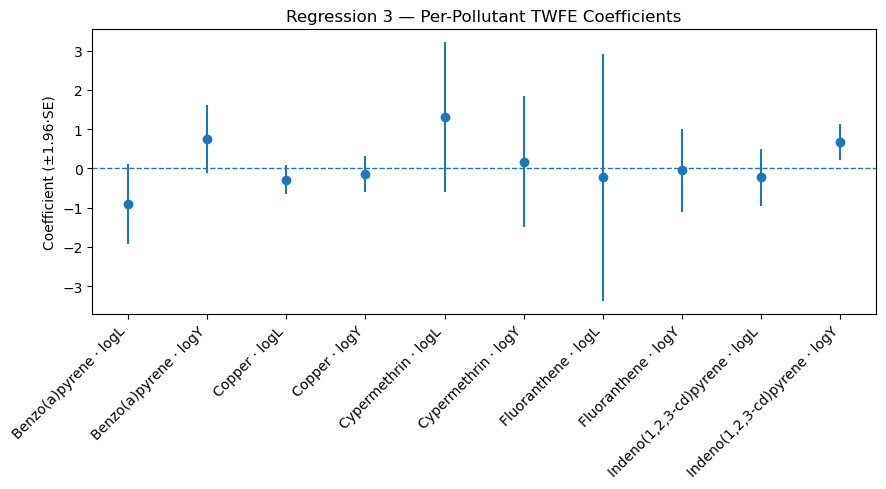

In [30]:
import matplotlib.pyplot as plt

if "A_tidy" in globals() and not A_tidy.empty:
    show = A_tidy[A_tidy["term"].isin(["log_turnover","log_employee"])].copy()
    show["x"] = show["pollutant"] + " · " + show["term"].map({"log_turnover":"logY","log_employee":"logL"})
    fig, ax = plt.subplots(figsize=(9,5))
    ax.errorbar(range(len(show)), show["coef"], yerr=1.96*show["se"], fmt="o")
    ax.axhline(0, linestyle="--", linewidth=1)
    ax.set_xticks(range(len(show)))
    ax.set_xticklabels(show["x"], rotation=45, ha="right")
    ax.set_ylabel("Coefficient (±1.96·SE)")
    ax.set_title("Regression 3 — Per-Pollutant TWFE Coefficients")
    plt.tight_layout()
    plt.show()
else:
    print("Error")


In [34]:
DECIMALS = 3
STAR_LEVELS = (0.10, 0.05, 0.01)
SHOW_STAT = "t"
ORDER = ["Benzo(a)pyrene","Copper","Cypermethrin","Fluoranthene","Indeno(1,2,3-cd)pyrene"]

def stars(p, a10=STAR_LEVELS[0], a5=STAR_LEVELS[1], a1=STAR_LEVELS[2]):
    return "***" if p<a1 else ("**" if p<a5 else ("*" if p<a10 else ""))

def apply_format(df, show_stat=SHOW_STAT, order=ORDER, dec=DECIMALS):
    if df.empty: 
        return df
    df = df.copy()
    if "pollutant" in df.columns and order:
        df["pollutant"] = pd.Categorical(df["pollutant"], categories=order, ordered=True)
        df = df.sort_values(["pollutant"])
    return df

paper_A_disp   = apply_format(paper_A)
paper_B1_disp  = apply_format(paper_B1)
paper_B2a_disp = apply_format(paper_B2a)
paper_B2b_disp = apply_format(paper_B2b)
paper_C_disp   = apply_format(paper_C)
paper_D_disp   = apply_format(paper_D)

if not paper_A_disp.empty:   style_table(paper_A_disp,  "R3-A. Panel TWFE per Pollutant")
if not paper_B1_disp.empty:  style_table(paper_B1_disp, "R3-B1. Productivity (log(Y/L)) Models")
if not paper_B2a_disp.empty: style_table(paper_B2a_disp,"R3-B2a. Intensity: log(E/Y) ~ log(Employees)")
if not paper_B2b_disp.empty: style_table(paper_B2b_disp,"R3-B2b. Intensity: log(E/L) ~ log(Turnover)")
if not paper_C_disp.empty:   style_table(paper_C_disp,  "R3-C. Unified Interactions within one TWFE")
if not paper_D_disp.empty:   style_table(paper_D_disp,  "R3-D. Cross-sectional OLS (SubSector & Year, HC3)")


pollutant,Log Employees,Log Turnover
Benzo(a)pyrene,-0.906 (0.519)*,0.747 (0.437)
Copper,-0.293 (0.188),-0.142 (0.238)
Cypermethrin,1.310 (0.971),0.167 (0.851)
Fluoranthene,-0.231 (1.603),-0.048 (0.541)
"Indeno(1,2,3-cd)pyrene",-0.232 (0.376),0.670 (0.240)**


pollutant,Log Employees,Log(Y/L)
Benzo(a)pyrene,-0.159 (0.386),0.747 (0.437)
Copper,-0.435 (0.338),-0.142 (0.238)
Cypermethrin,1.476 (1.151),0.167 (0.851)
Fluoranthene,-0.279 (1.869),-0.048 (0.541)
"Indeno(1,2,3-cd)pyrene",0.439 (0.051)***,0.670 (0.278)**


pollutant,Log Employees
Benzo(a)pyrene,-1.099 (0.424)**
Copper,0.785 (0.559)
Cypermethrin,1.412 (0.942)
Fluoranthene,-0.353 (1.866)
"Indeno(1,2,3-cd)pyrene",-0.497 (0.227)**


pollutant,Log Turnover
Benzo(a)pyrene,0.267 (0.488)
Copper,0.105 (0.257)
Cypermethrin,0.130 (0.845)
Fluoranthene,-0.075 (0.648)
"Indeno(1,2,3-cd)pyrene",0.319 (0.235)


pollutant,Log Employees,Log Turnover
Benzo(a)pyrene,-0.074 (0.417),0.638 (0.231)***
Copper,1.142 (0.434)***,0.024 (0.295)
Cypermethrin,0.386 (0.390),0.111 (0.305)
Fluoranthene,-0.295 (0.511),0.738 (0.356)**
"Indeno(1,2,3-cd)pyrene",-0.164 (0.522),0.804 (0.321)**


pollutant,Log Employees,Log Turnover
Benzo(a)pyrene,-1.165 (1.241),2.867 (1.045)***
Copper,0.363 (0.505),0.537 (0.464)
Cypermethrin,-2.657 (1.059)**,1.627 (0.468)***
Fluoranthene,2.398 (0.663)***,-0.624 (0.783)
"Indeno(1,2,3-cd)pyrene",-0.387 (1.163),2.214 (0.933)**


In [43]:
# 从 A_tidy / A_results 汇总信息
import pandas as pd

info = (A_tidy.groupby("pollutant")
                .agg(firms=("firms","first"),
                     years=("years","first"),
                     nobs=("nobs","first"))
                .reset_index())

# 取 R² 和协方差类型
r2_list, cov_list = [], []
for p in info["pollutant"]:
    res, cov_used = A_results[p]   # 你步骤4里存的是 (res, cov_used)
    r2_list.append(getattr(res, "rsquared_within", float("nan")))
    cov_list.append(cov_used)
info["R2_within"] = r2_list
info["cov_used"]  = cov_list

# 漂亮显示
style_table(info[["pollutant","firms","years","nobs","R2_within","cov_used"]],
            "Appendix A. Panel sizes & covariance used",
            "Cluster sizes and covariance estimator for the TWFE models.")


pollutant,firms,years,nobs,R2_within,cov_used
Benzo(a)pyrene,7,8,39,-0.027360,2-way cluster (firm & year)
Copper,15,8,81,0.025555,2-way cluster (firm & year)
Cypermethrin,10,8,43,0.105668,2-way cluster (firm & year)
Fluoranthene,11,8,57,0.009192,2-way cluster (firm & year)
"Indeno(1,2,3-cd)pyrene",7,8,40,0.070031,1-way cluster (firm)


In [36]:
import numpy as np
from scipy import stats

b, V = resC.params, np.asarray(resC.cov)

def wald_diff(name1, name2):
    idx = {k:i for i,k in enumerate(b.index)}
    L = np.zeros(len(b)); L[idx[name1]] = 1; L[idx[name2]] = -1
    diff = float(b[name1] - b[name2])
    var  = float(L @ V @ L)
    W = diff**2 / var
    p = 1 - stats.chi2.cdf(W, 1)
    return diff, np.sqrt(var), W, p

pairs = [
    ("logY_x_Poll_Benzo(a)pyrene", "logY_x_Poll_Copper"),
    ("logY_x_Poll_Benzo(a)pyrene", "logY_x_Poll_Cypermethrin"),
    ("logY_x_Poll_Fluoranthene",   "logY_x_Poll_Copper"),
    ("logY_x_Poll_Indeno(1,2,3-cd)pyrene", "logY_x_Poll_Copper"),
]

rows=[]
for a,bn in pairs:
    d,se,W,p = wald_diff(a,bn)
    rows.append({"H0": f"{a} = {bn}", "diff": d, "se(diff)": se, "Chi2(1)": W, "p": p})

wald_tbl = pd.DataFrame(rows)
style_table(wald_tbl, "Appendix B. Wald tests for cross-pollutant equality")


H0,diff,se(diff),Chi2(1),p
logY_x_Poll_Benzo(a)pyrene = logY_x_Poll_Copper,0.613949,0.299254,4.209045,0.040209
logY_x_Poll_Benzo(a)pyrene = logY_x_Poll_Cypermethrin,0.526257,0.216805,5.891938,0.015210
logY_x_Poll_Fluoranthene = logY_x_Poll_Copper,0.714168,0.488535,2.137026,0.143780
"logY_x_Poll_Indeno(1,2,3-cd)pyrene = logY_x_Poll_Copper",0.780704,0.467204,2.792291,0.094719
